In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Gaussian Process Classification with Laplace Approximation

### Objective

In Gaussian Process Classification (GPC), we approximate the posterior distribution of the latent variables $ \mathbf{a}_N $, given the training data $ \mathbf{t}_N $, using the **Laplace approximation**.

The posterior is expressed as:

$$
\Psi(\mathbf{a}_N) = \ln p(\mathbf{a}_N | \theta) + \ln p(\mathbf{t}_N | \mathbf{a}_N)
$$

---

## Gradient of $ \ln p(\mathbf{t}_N | \theta) $ with Respect to $ \theta $

To optimize the parameters $ \theta $, we compute the gradient of $ \ln p(\mathbf{t}_N | \theta) $ with respect to $ \theta $. Changes in $ \theta $ affect both:

1. The covariance matrix $ C_N $.
2. The latent variables $ \mathbf{a}_N $.

Differentiating, we obtain:

$$
\frac{\partial \ln p(\mathbf{t}_N | \theta)}{\partial \theta_j} =
\underbrace{\frac{1}{2} \mathbf{a}_N^\top C_N^{-1} \frac{\partial C_N}{\partial \theta_j} C_N^{-1} \mathbf{a}_N
- \frac{1}{2} \text{Tr}\left( (I + C_N W_N)^{-1} W_N \frac{\partial C_N}{\partial \theta_j} \right)}_{\text{Explicit dependence on } \theta}
$$

---

## Laplace Approximation and Contributions

The Laplace approximation constructs $ \Psi(\mathbf{a}_N) $ such that its gradient is zero at $ \mathbf{a}_N = \mathbf{a}^*_N $. Thus, $ \Psi(\mathbf{a}^*_N) $ does not contribute to the gradient due to its dependence on $ \mathbf{a}_N $.

This results in the following contribution:

$$
\frac{\partial \ln |\mathbf{W}_N + C_N^{-1}|}{\partial a^*_n}
- \frac{1}{2} \sum_{n=1}^N \frac{\partial a^*_n}{\partial \theta_j}
$$

Using the logistic sigmoid $ \sigma_n = \sigma(a^*_n) $, this becomes:

$$
-\frac{1}{2} \text{Tr}\left( (I + W_N C_N)^{-1} C_N \frac{\partial C_N}{\partial \theta_j} \right)
\sigma_n (1 - \sigma_n)(1 - 2\sigma_n)
$$

---

## Derivatives of $ \mathbf{a}^*_N $ with Respect to $ \theta $

From the relation:

$$
\frac{\partial \mathbf{a}^*_N}{\partial \theta_j} =
(I + W_N C_N)^{-1} (t_N - \sigma_N)
$$

Combining results, the gradient becomes:

$$
\frac{\partial \ln p(\mathbf{t}_N | \theta)}{\partial \theta_j} =
\text{(Explicit term)} + \text{(Implicit term from } \mathbf{a}^*_N \text{ dependence)}
$$

---

## Visualization and Application

 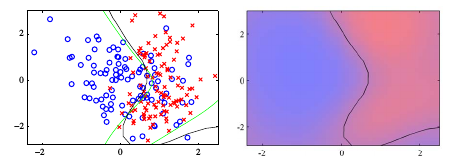
 
 Fig.12 Illustration of the use of a Gaussian process for classiﬁcation, showing the data on the left together with the optimal decision boundary from the true distribution in green, and the decision boundary from the Gaussian process classiﬁer in black. On the right is the predicted posterior probability for the blue and red classes together with the Gaussian process decision boundary.
                                
In **Fig.12** (not included here):

- The **true decision boundary** is shown in green.
- The **Gaussian process classifier decision boundary** is shown in black.
- The **posterior probabilities** for the blue and red classes are also visualized.

### Multi-class Extension

The Laplace approximation can be extended to multi-class Gaussian Process Classification using the **softmax activation function**, as described by Williams and Barber (1998).

---



In [1]:
import math

# Sigmoid (logistic) function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Squared Exponential Kernel function
def squared_exponential_kernel(x1, x2, length_scale):
    sq_dist = sum((x1[i] - x2[i]) ** 2 for i in range(len(x1)))
    return math.exp(-0.5 * sq_dist / length_scale ** 2)

# Build the covariance matrix
def build_covariance_matrix(X, length_scale):
    N = len(X)
    C = [[squared_exponential_kernel(X[i], X[j], length_scale) for j in range(N)] for i in range(N)]
    return C

# Matrix inversion (simple implementation)
def invert_matrix(matrix):
    n = len(matrix)
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    for i in range(n):
        diag = matrix[i][i]
        for j in range(n):
            matrix[i][j] /= diag
            identity[i][j] /= diag
        for k in range(n):
            if k != i:
                factor = matrix[k][i]
                for j in range(n):
                    matrix[k][j] -= factor * matrix[i][j]
                    identity[k][j] -= factor * identity[i][j]
    return identity

# Gradient and Hessian of log-posterior
def compute_gradient_hessian(a_N, t_N, C_inv):
    N = len(a_N)
    gradient = [t_N[i] - sigmoid(a_N[i]) - sum(C_inv[i][j] * a_N[j] for j in range(N)) for i in range(N)]
    W = [[0] * N for _ in range(N)]
    for i in range(N):
        sigma = sigmoid(a_N[i])
        W[i][i] = sigma * (1 - sigma)
    Hessian = [[W[i][j] + C_inv[i][j] if i == j else C_inv[i][j] for j in range(N)] for i in range(N)]
    return gradient, Hessian

# Laplace approximation
def laplace_approximation(X, t, length_scale, max_iter=100, tol=1e-5):
    N = len(X)
    C = build_covariance_matrix(X, length_scale)
    C_inv = invert_matrix(C)

    # Initialize latent variables
    a_N = [0] * N

    for iteration in range(max_iter):
        gradient, Hessian = compute_gradient_hessian(a_N, t, C_inv)

        # Hessian inversion (Newton-Raphson step)
        Hessian_inv = invert_matrix(Hessian)
        update = [sum(Hessian_inv[i][j] * gradient[j] for j in range(N)) for i in range(N)]

        # Update latent variables
        a_N = [a_N[i] - update[i] for i in range(N)]

        # Convergence check
        if max(abs(update[i]) for i in range(N)) < tol:
            break

    # Compute predictive mean and variance
    W = [[0] * N for _ in range(N)]
    for i in range(N):
        sigma = sigmoid(a_N[i])
        W[i][i] = sigma * (1 - sigma)

    Hessian = [[W[i][j] + C_inv[i][j] if i == j else C_inv[i][j] for j in range(N)] for i in range(N)]
    Hessian_inv = invert_matrix(Hessian)

    return a_N, Hessian_inv

# Example Usage
if __name__ == "__main__":
    # Synthetic dataset
    X_train = [[0], [1], [2]]
    t_train = [0, 1, 0]
    length_scale = 1.0

    a_N, Hessian_inv = laplace_approximation(X_train, t_train, length_scale)

    print("Latent Variables at Mode (a_N):", a_N)
    print("Posterior Covariance Matrix (Hessian^-1):", Hessian_inv)


Latent Variables at Mode (a_N): [3.0956952448590548e+29, 1.0541885405035667e+29, 3.0956952448590745e+29]
Posterior Covariance Matrix (Hessian^-1): [[0.9999999999999999, 0.6065306597126334, 0.13533528323661273], [0.6065306597126333, 1.0, 0.6065306597126335], [0.13533528323661279, 0.6065306597126336, 1.0000000000000002]]


## Connection to Neural Networks

We explore the relationship between Gaussian processes (GPs) and neural networks (NNs). This connection offers insights into both methods and their underlying principles.

## Representational Capacity of Neural Networks

We have seen that the range of functions represented by a neural network is governed by the number of hidden units, denoted by $M$. For sufficiently large $M$, a two-layer neural network can approximate any given function with arbitrary accuracy. 

From a **maximum likelihood** perspective:
- The number of hidden units needs to be limited based on the size of the training set to avoid **overfitting**.

From a **Bayesian** perspective:
- It makes little sense to constrain the number of parameters based on the size of the training set.
- Instead, the prior distribution over the parameter vector $ \mathbf{w} $, combined with the network function $ f(\mathbf{x}, \mathbf{w}) $, defines a **prior distribution over functions** $y(\mathbf{x})$, where $y$ is the vector of network outputs.

## Connection to Gaussian Processes

Neal (1996) demonstrated that:
- For a broad class of prior distributions over $ \mathbf{w} $, the distribution of functions generated by a neural network converges to a **Gaussian process** in the limit as $ M \to \infty $.

However, in this limit:
- The output variables of the neural network become **independent**.
- A key property of neural networks is lost: **shared hidden units**, which allow the outputs to "borrow statistical strength" from one another. In neural networks, the weights associated with hidden units are influenced by all outputs, not just one.

## Covariance Functions and Gaussian Processes

A **Gaussian process** is fully specified by its **covariance (kernel) function**. Williams (1998) provided explicit forms for the covariance functions in two specific cases of hidden unit activation functions:
1. **Probit activation function**.
2. **Gaussian activation function**.

These kernel functions, denoted as $ k(\mathbf{x}, \mathbf{x}') $, are **nonstationary**:
- They cannot be expressed solely as a function of the difference $ \mathbf{x} - \mathbf{x}' $.
- This nonstationarity arises because the Gaussian weight prior is centered at zero, which breaks translation invariance in weight space.

By working directly with the covariance function, we:
- **Implicitly marginalize** over the distribution of weights.
- Use hyperparameters of the weight prior to determine the length scales of the function distribution. For instance, as seen in **Figure 5.11**, the length scales are influenced by the number of hidden units.

## Marginalization Over Hyperparameters

It is important to note:
- Hyperparameters cannot be marginalized analytically.
- Instead, techniques such as **numerical integration** or **optimization** must be employed.

---



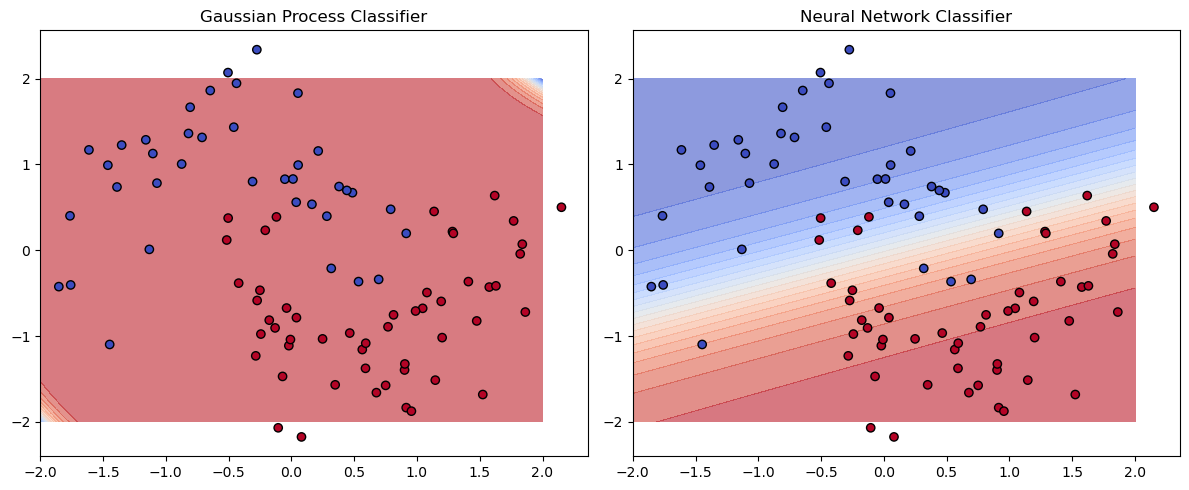

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.reshape(-1, 1)  # Convert labels to column vector

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -------------------------
# Helper Functions
# -------------------------
def sigmoid(x):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-x))

def rbf_kernel(X1, X2, length_scale=1.0):
    """Radial Basis Function (RBF) kernel."""
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 / length_scale**2 * sqdist)

# -------------------------
# Gaussian Process Classifier
# -------------------------
class GaussianProcessClassifier:
    def __init__(self, length_scale=1.0, noise=1e-6):
        self.length_scale = length_scale
        self.noise = noise

    def fit(self, X, y):
        """Fit the GPC using Laplace approximation."""
        self.X_train = X
        self.y_train = y
        N = X.shape[0]
        
        # Compute the kernel matrix
        K = rbf_kernel(X, X, self.length_scale)
        self.K = K + self.noise * np.eye(N)  # Add noise for numerical stability

        # Initialize latent function values (a_N)
        a_N = np.zeros(N)
        
        # Laplace approximation (Newton's method)
        for _ in range(10):  # Fixed number of iterations
            sigma = sigmoid(a_N)
            W = np.diag(sigma.flatten() * (1 - sigma.flatten()))  # Diagonal weight matrix
            z = np.dot(self.K, a_N) - np.linalg.solve(W + np.linalg.inv(self.K), a_N - self.y_train.flatten())
            a_N = z

        self.a_N = a_N
        self.W = W

    def predict_proba(self, X):
        """Predict probabilities using the fitted model."""
        K_s = rbf_kernel(X, self.X_train, self.length_scale)
        W_inv = np.linalg.inv(np.eye(self.W.shape[0]) + self.W @ self.K)
        f_star = K_s @ np.linalg.solve(self.K, self.a_N)
        v = K_s @ W_inv @ K_s.T
        p = sigmoid(f_star)
        return p, np.diag(v)

    def predict(self, X):
        """Predict class labels."""
        p, _ = self.predict_proba(X)
        return (p > 0.5).astype(int)

# -------------------------
# Simple Neural Network
# -------------------------
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        self.lr = lr
        # Initialize weights and biases
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros(output_dim)

    def forward(self, X):
        """Forward pass."""
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = np.tanh(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        return self.A2

    def backward(self, X, y, y_pred):
        """Backward pass and gradient descent."""
        m = X.shape[0]
        dZ2 = y_pred - y
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0) / m
        dZ1 = np.dot(dZ2, self.W2.T) * (1 - self.A1**2)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0) / m

        # Gradient descent update
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y, epochs=1000):
        """Train the neural network."""
        for _ in range(epochs):
            y_pred = self.forward(X)
            self.backward(X, y, y_pred)

    def predict(self, X):
        """Predict class labels."""
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

# -------------------------
# Training and Visualization
# -------------------------
# Train Gaussian Process Classifier
gpc = GaussianProcessClassifier(length_scale=1.0, noise=1e-6)
gpc.fit(X_train, y_train)

# Train Simple Neural Network
nn = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1, lr=0.1)
nn.train(X_train, y_train, epochs=500)

# Create a mesh grid for decision boundaries
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# GPC Predictions
gpc_probs, _ = gpc.predict_proba(grid)
gpc_preds = gpc_probs.reshape(xx.shape)

# NN Predictions
nn_preds = nn.forward(grid).reshape(xx.shape)

# Plot decision boundaries
plt.figure(figsize=(12, 5))

# Gaussian Process Classifier
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, gpc_preds, levels=20, cmap="coolwarm", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), edgecolor='k', cmap="coolwarm")
plt.title("Gaussian Process Classifier")

# Neural Network Classifier
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, nn_preds, levels=20, cmap="coolwarm", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), edgecolor='k', cmap="coolwarm")
plt.title("Neural Network Classifier")

plt.tight_layout()
plt.show()


In [6]:
import math
import random

# Generate synthetic dataset (2D binary classification)
def generate_moons(n_samples=300, noise=0.2, seed=42):
    random.seed(seed)
    points = []
    labels = []
    for i in range(n_samples):
        angle = random.uniform(0, math.pi)
        if random.random() < 0.5:
            x = math.cos(angle) + noise * random.uniform(-1, 1)
            y = math.sin(angle) + noise * random.uniform(-1, 1)
            label = 0
        else:
            x = 1 - math.cos(angle) + noise * random.uniform(-1, 1)
            y = -math.sin(angle) + noise * random.uniform(-1, 1)
            label = 1
        points.append([x, y])
        labels.append(label)
    return points, labels

# Split dataset into train and test
def train_test_split(data, labels, test_size=0.3, seed=42):
    random.seed(seed)
    indices = list(range(len(data)))
    random.shuffle(indices)
    split = int(len(data) * (1 - test_size))
    train_indices = indices[:split]
    test_indices = indices[split:]
    train_data = [data[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    test_data = [data[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]
    return train_data, train_labels, test_data, test_labels

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0):
    sqdist = sum((x1[i] - x2[i]) ** 2 for i in range(len(x1)))
    return math.exp(-0.5 * sqdist / (length_scale ** 2))

# Gaussian Process Classifier
class GaussianProcessClassifier:
    def __init__(self, length_scale=1.0, noise=1e-6):
        self.length_scale = length_scale
        self.noise = noise

    def fit(self, X, y):
        N = len(X)
        self.X_train = X
        self.y_train = y

        # Compute kernel matrix with noise
        self.K = [[rbf_kernel(X[i], X[j], self.length_scale) for j in range(N)] for i in range(N)]
        for i in range(N):
            self.K[i][i] += self.noise

        # Initialize latent variables
        self.a_N = [0] * N

        # Laplace approximation (Newton's method)
        for _ in range(10):
            sigma = [sigmoid(self.a_N[i]) for i in range(N)]
            W = [max(sigma[i] * (1 - sigma[i]), 1e-6) for i in range(N)]  # Avoid zero by adding a small epsilon
            for i in range(N):
                z = sum(self.K[i][j] * self.a_N[j] for j in range(N)) - \
                    (self.a_N[i] - self.y_train[i]) / W[i]
                self.a_N[i] = z


    def predict(self, X):
        preds = []
        for x in X:
            k_star = [rbf_kernel(x, self.X_train[i], self.length_scale) for i in range(len(self.X_train))]
            f_star = sum(k_star[i] * self.a_N[i] for i in range(len(k_star)))
            preds.append(1 if sigmoid(f_star) > 0.5 else 0)
        return preds

# Simple Neural Network
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        self.learning_rate = lr
        self.W1 = [[random.uniform(-0.1, 0.1) for _ in range(hidden_dim)] for _ in range(input_dim)]
        self.b1 = [0] * hidden_dim
        self.W2 = [[random.uniform(-0.1, 0.1) for _ in range(output_dim)] for _ in range(hidden_dim)]
        self.b2 = [0] * output_dim
        
        
        

    def forward(self, X):
        self.Z1 = [[sum(X[i][j] * self.W1[j][k] for j in range(len(X[0]))) + self.b1[k]
                    for k in range(len(self.W1[0]))] for i in range(len(X))]
        self.A1 = [[math.tanh(self.Z1[i][j]) for j in range(len(self.Z1[0]))] for i in range(len(self.Z1))]
        self.Z2 = [[sum(self.A1[i][j] * self.W2[j][k] for j in range(len(self.W2))) + self.b2[k]
                    for k in range(len(self.W2[0]))] for i in range(len(self.A1))]
        self.A2 = [[sigmoid(self.Z2[i][j]) for j in range(len(self.Z2[0]))] for i in range(len(self.Z2))]
        return self.A2

    def backward(self, X, y):
        # Ensure y is one-hot-encoded
        if isinstance(y[0], int):  # Check if y is a list of class indices
            y_one_hot = [[1 if j == y[i] else 0 for j in range(len(self.A2[0]))] for i in range(len(y))]
        else:
            y_one_hot = y  # Assume y is already one-hot encoded

        # Gradients for output layer
        dZ2 = [[self.A2[i][j] - y_one_hot[i][j] for j in range(len(self.A2[0]))] for i in range(len(self.A2))]
        dW2 = [[sum(dZ2[i][j] * self.A1[i][k] for i in range(len(X))) / len(X) for j in range(len(dZ2[0]))]
               for k in range(len(self.A1[0]))]
        db2 = [sum(dZ2[i][j] for i in range(len(X))) / len(X) for j in range(len(dZ2[0]))]

        # Gradients for hidden layer
        dZ1 = [[sum(dZ2[i][j] * self.W2[k][j] for j in range(len(self.W2[0]))) *
                self.A1[i][k] * (1 - self.A1[i][k]) for k in range(len(self.A1[0]))] for i in range(len(X))]
        dW1 = [[sum(dZ1[i][k] * X[i][m] for i in range(len(X))) / len(X) for k in range(len(dZ1[0]))]
               for m in range(len(X[0]))]
        db1 = [sum(dZ1[i][k] for i in range(len(X))) / len(X) for k in range(len(dZ1[0]))]

        # Update weights and biases
        self.W2 = [[self.W2[k][j] - self.learning_rate * dW2[k][j] for j in range(len(self.W2[0]))] for k in range(len(self.W2))]
        self.b2 = [self.b2[j] - self.learning_rate * db2[j] for j in range(len(self.b2))]
        self.W1 = [[self.W1[m][k] - self.learning_rate * dW1[m][k] for k in range(len(self.W1[0]))] for m in range(len(self.W1))]
        self.b1 = [self.b1[k] - self.learning_rate * db1[k] for k in range(len(self.b1))]


    def train(self, X, y, epochs=1000):
        for _ in range(epochs):
            self.forward(X)
            self.backward(X, y)

    def predict(self, X):
        outputs = self.forward(X)
        return [1 if outputs[i][0] > 0.5 else 0 for i in range(len(outputs))]

# -------------------------
# Training and Testing
# -------------------------
# Generate and split data
data, labels = generate_moons()
X_train, y_train, X_test, y_test = train_test_split(data, labels)

# Train Gaussian Process Classifier
gpc = GaussianProcessClassifier(length_scale=1.0, noise=1e-6)
gpc.fit(X_train, y_train)
gpc_preds = gpc.predict(X_test)

# Train Neural Network
nn = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1, lr=0.1)
nn.train(X_train, [[y] for y in y_train], epochs=500)
nn_preds = nn.predict(X_test)

# Accuracy
gpc_acc = sum(1 for i in range(len(y_test)) if gpc_preds[i] == y_test[i]) / len(y_test)
nn_acc = sum(1 for i in range(len(y_test)) if nn_preds[i] == y_test[i]) / len(y_test)

print(f"GPC Accuracy: {gpc_acc}")
print(f"NN Accuracy: {nn_acc}")


GPC Accuracy: 0.4777777777777778
NN Accuracy: 0.9333333333333333


Epoch 0/100 - Loss: 0.2558 - Accuracy: 0.3400
Epoch 10/100 - Loss: 0.2529 - Accuracy: 0.3400
Epoch 20/100 - Loss: 0.2503 - Accuracy: 0.3400
Epoch 30/100 - Loss: 0.2479 - Accuracy: 0.3400
Epoch 40/100 - Loss: 0.2458 - Accuracy: 0.3400
Epoch 50/100 - Loss: 0.2439 - Accuracy: 0.3400
Epoch 60/100 - Loss: 0.2422 - Accuracy: 0.3400
Epoch 70/100 - Loss: 0.2406 - Accuracy: 0.3400
Epoch 80/100 - Loss: 0.2392 - Accuracy: 0.3400
Epoch 90/100 - Loss: 0.2380 - Accuracy: 0.3500


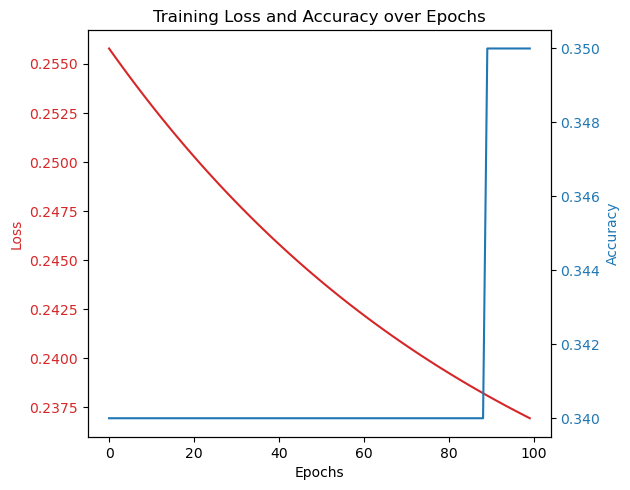

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size)  # Weights for input to hidden layer
        self.b1 = np.zeros(hidden_size)  # Biases for hidden layer
        self.W2 = np.random.randn(hidden_size, output_size)  # Weights for hidden to output layer
        self.b2 = np.zeros(output_size)  # Biases for output layer
        
        self.learning_rate = learning_rate  # Initialize learning rate

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X):
        # Forward pass: input -> hidden -> output
        self.A1 = np.dot(X, self.W1) + self.b1  # Linear transformation for hidden layer
        self.Z1 = self.sigmoid(self.A1)  # Apply activation function (sigmoid) to hidden layer
        self.A2 = np.dot(self.Z1, self.W2) + self.b2  # Linear transformation for output layer
        self.Z2 = self.sigmoid(self.A2)  # Apply activation function (sigmoid) to output layer
        return self.Z2

    def backward(self, X, y):
        # Ensure y is one-hot-encoded
        if isinstance(y[0], int):  # Check if y is a list of class indices
            y_one_hot = [[1 if j == y[i] else 0 for j in range(len(self.A2[0]))] for i in range(len(y))]
        else:
            y_one_hot = y  # Assume y is already one-hot encoded

        # Gradients for output layer
        dZ2 = [[self.Z2[i][j] - y_one_hot[i][j] for j in range(len(self.Z2[0]))] for i in range(len(self.Z2))]
        dW2 = [[sum(dZ2[i][j] * self.Z1[i][k] for i in range(len(X))) / len(X) for j in range(len(dZ2[0]))]
               for k in range(len(self.Z1[0]))]
        db2 = [sum(dZ2[i][j] for i in range(len(X))) / len(X) for j in range(len(dZ2[0]))]

        # Gradients for hidden layer
        dZ1 = [[sum(dZ2[i][j] * self.W2[k][j] for j in range(len(self.W2[0]))) *
                self.Z1[i][k] * (1 - self.Z1[i][k]) for k in range(len(self.Z1[0]))] for i in range(len(X))]
        dW1 = [[sum(dZ1[i][k] * X[i][m] for i in range(len(X))) / len(X) for k in range(len(dZ1[0]))]
               for m in range(len(X[0]))]
        db1 = [sum(dZ1[i][k] for i in range(len(X))) / len(X) for k in range(len(dZ1[0]))]

        # Update weights and biases
        self.W2 = [[self.W2[k][j] - self.learning_rate * dW2[k][j] for j in range(len(self.W2[0]))] for k in range(len(self.W2))]
        self.b2 = [self.b2[j] - self.learning_rate * db2[j] for j in range(len(self.b2))]
        self.W1 = [[self.W1[m][k] - self.learning_rate * dW1[m][k] for k in range(len(self.W1[0]))] for m in range(len(self.W1))]
        self.b1 = [self.b1[k] - self.learning_rate * db1[k] for k in range(len(self.b1))]

    def train(self, X, y, epochs=100):
        loss_history = []
        accuracy_history = []
        
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)
            
            # Compute loss (mean squared error)
            loss = np.mean((y_pred - y) ** 2)
            loss_history.append(loss)
            
            # Compute accuracy (mean number of correct predictions)
            predictions = np.argmax(y_pred, axis=1)
            accuracy = np.mean(predictions == np.argmax(y, axis=1))
            accuracy_history.append(accuracy)
            
            # Backward pass
            self.backward(X, y)
            
            # Print loss and accuracy every 10 epochs
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}')
        
        # Plotting loss and accuracy
        self.plot_training_metrics(loss_history, accuracy_history)
    
    def plot_training_metrics(self, loss_history, accuracy_history):
        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.plot(loss_history, color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='tab:blue')
        ax2.plot(accuracy_history, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        fig.tight_layout()
        plt.title("Training Loss and Accuracy over Epochs")
        plt.show()

# Example usage
X_train = np.random.randn(100, 3)  # 100 samples, 3 features
y_train = [0, 1, 2] * 33 + [0]  # 100 samples, 3 classes (encoded as indices)
y_train_one_hot = np.eye(3)[y_train]  # Convert to one-hot encoding

# Initialize the neural network
nn = SimpleNN(input_size=3, hidden_size=5, output_size=3, learning_rate=0.01)

# Train the neural network
nn.train(X_train, y_train_one_hot, epochs=100)
